In [51]:
# =========================
# Core Libraries
# =========================
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Scikit-learn
# =========================
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# TensorFlow / Keras
# =========================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [52]:
df = pd.read_csv("saved_model/dataset/Language Detection.csv")
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [54]:
df.duplicated().sum()

66

In [55]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [56]:
df.Language.unique()

array(['English', 'Malayalam', 'Hindi', 'Tamil', 'Portugeese', 'French',
       'Dutch', 'Spanish', 'Greek', 'Russian', 'Danish', 'Italian',
       'Turkish', 'Sweedish', 'Arabic', 'German', 'Kannada'], dtype=object)

In [57]:
# Count how many samples exist for each language
df.Language.value_counts() 

Language
English       1382
French        1007
Spanish        816
Portugeese     736
Italian        694
Russian        688
Sweedish       673
Malayalam      591
Dutch          542
Arabic         532
Turkish        471
German         465
Tamil          464
Danish         424
Kannada        366
Greek          358
Hindi           62
Name: count, dtype: int64

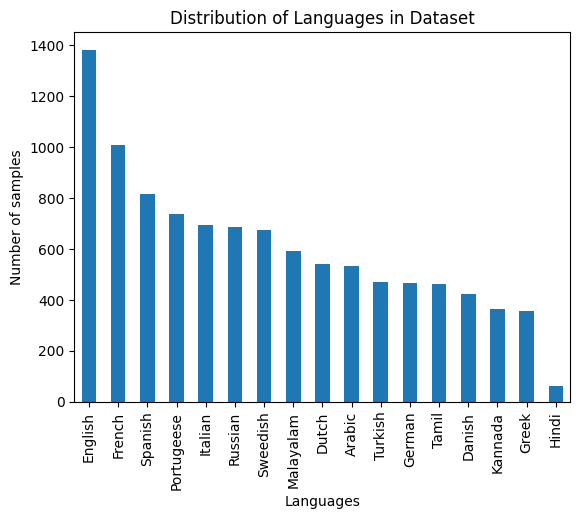

In [58]:
# Class Imbalance Visualization
df.Language.value_counts().plot(kind='bar')
plt.xlabel('Languages')
plt.ylabel('Number of samples')
plt.title('Distribution of Languages in Dataset')
plt.show()

In [59]:
# Encode labels
label_encoder = LabelEncoder()
df["Language_encoded"] = label_encoder.fit_transform(df["Language"])

In [60]:
print(df.Language.unique())
print(df.Language_encoded.unique())

['English' 'Malayalam' 'Hindi' 'Tamil' 'Portugeese' 'French' 'Dutch'
 'Spanish' 'Greek' 'Russian' 'Danish' 'Italian' 'Turkish' 'Sweedish'
 'Arabic' 'German' 'Kannada']
[ 3 10  7 15 11  4  2 13  6 12  1  8 16 14  0  5  9]


In [61]:
df.drop("Language_encoded", axis=1, inplace=True)
df["Language"] = label_encoder.fit_transform(df["Language"])

In [62]:
# Tokenization ==> Each word is assigned a unique number (token)
# Keeps only the top 15,000 most frequent words
# Rare words are ignored
# OOV = Out Of Vocabulary ==> Any word not in top 15,000 is replaced by <OOV>
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
# Word-to-Index Mapping ==> 
#   Counts word frequency
#   Assigns indexes based on frequency
tokenizer.fit_on_texts(df["Text"]) # Builds vocabulary dictionary

In [63]:
sequences = tokenizer.texts_to_sequences(df["Text"])
# Converts text sentences into numeric sequences using the vocabulary
sequences[:3]

[[84, 8, 4, 11195, 4933, 22, 4, 702, 2714, 1386, 959, 115, 2715],
 [84, 152, 7998, 14, 4, 11196, 9, 4, 2714, 959, 11, 236, 14, 324, 8, 730],
 [4, 787, 9, 84, 22, 3, 1189, 255, 201, 4, 516, 468, 9, 602]]

In [83]:
X = pad_sequences(sequences, maxlen=60)
X

array([[   0,    0,    0, ...,  959,  115, 2715],
       [   0,    0,    0, ...,  324,    8,  730],
       [   0,    0,    0, ...,  468,    9,  602],
       ...,
       [   0,    0,    0, ...,    1,  650,    1],
       [   0,    0,    0, ...,  136, 8588,    1],
       [   0,    0,    0, ...,    1,  650,    1]])

In [65]:
X.shape

(10271, 80)

In [66]:
y = df["Language"]

In [67]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Compute class weights
# "balanced" means higher weight is given to rare classes
# unique class labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

In [69]:
# Convert class weights into dictionary format
# Required by Keras while training the model
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.1758980964648633,
 1: 1.4256463647405866,
 2: 1.1135809162374628,
 3: 0.4425770308123249,
 4: 0.6063916156173887,
 5: 1.2751823684618966,
 6: 1.649467978317607,
 7: 8.949891067538127,
 8: 0.8569044639132248,
 9: 1.6327503974562798,
 10: 1.0304778627869058,
 11: 0.8095378855059612,
 12: 0.849374547710121,
 13: 0.736728837876614,
 14: 0.9240805308739174,
 15: 1.278555866791161,
 16: 1.3240934730056406}

In [70]:
classes_ = label_encoder.classes_

In [71]:
# SimpleRNN model
model = Sequential([
    # Embedding layer converts words into dense vectors
    # Each word is represented as a 64-dimensional vector
    # vocabulary size = 15000
    # Input sequence length = 80 (input + padding)
    Embedding(input_dim=15000, output_dim=64, input_length=80),
    # SimpleRNN layer to capture sequence patterns
    SimpleRNN(64),
    Dropout(0.3),
    Dense(len(classes_), activation="softmax")
])

In [72]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [73]:
# Reduced learning rate
optimizer = Adam(learning_rate=0.0005)

In [74]:
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [75]:
# Train model with class weights
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/100


514/514 [==============================] - 12s 19ms/step - loss: 2.5998 - accuracy: 0.1784 - val_loss: 1.9663 - val_accuracy: 0.3864
Epoch 2/100
514/514 [==============================] - 8s 16ms/step - loss: 1.5066 - accuracy: 0.6635 - val_loss: 0.9269 - val_accuracy: 0.8530
Epoch 3/100
514/514 [==============================] - 8s 16ms/step - loss: 0.7123 - accuracy: 0.8948 - val_loss: 0.5458 - val_accuracy: 0.8978
Epoch 4/100
514/514 [==============================] - 8s 16ms/step - loss: 0.3531 - accuracy: 0.9550 - val_loss: 0.3066 - val_accuracy: 0.9426
Epoch 5/100
514/514 [==============================] - 8s 15ms/step - loss: 0.2104 - accuracy: 0.9699 - val_loss: 0.2687 - val_accuracy: 0.9397
Epoch 6/100
514/514 [==============================] - 8s 16ms/step - loss: 0.1482 - accuracy: 0.9759 - val_loss: 0.2313 - val_accuracy: 0.9436
Epoch 7/100
514/514 [==============================] - 8s 16ms/step - loss: 0.1385 - accuracy: 0.9750 - val_loss: 0.1923 - val_accura

In [76]:
# Save model
model.save("saved_model/simple_rnn_model.h5")

# Save tokenizer & label encoder
with open("saved_model/tokenizer.pkl", "wb") as f:
    pickle.dump((tokenizer, label_encoder), f)

print("Model training completed and saved.")

Model training completed and saved.


c:\Users\ayush\.conda\envs\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Model Loading**

In [77]:
#load model
model = load_model("saved_model/simple_rnn_model.h5")

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

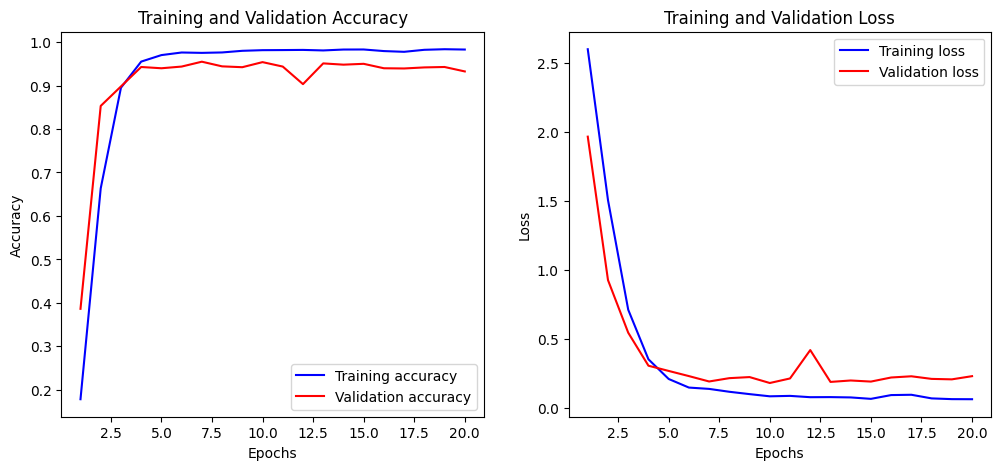

In [79]:
plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [80]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

65/65 [==============================] - 0s 3ms/step - loss: 0.1813 - accuracy: 0.9538
Test Accuracy: 0.9538
Test Loss: 0.1813


In [81]:
# Predictions on Test Data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
# Finds the index of maximum probability

y_pred_classes[:10]

65/65 [==============================] - 0s 3ms/step


array([16, 16,  4,  3, 11,  3,  0,  4,  6, 16], dtype=int64)

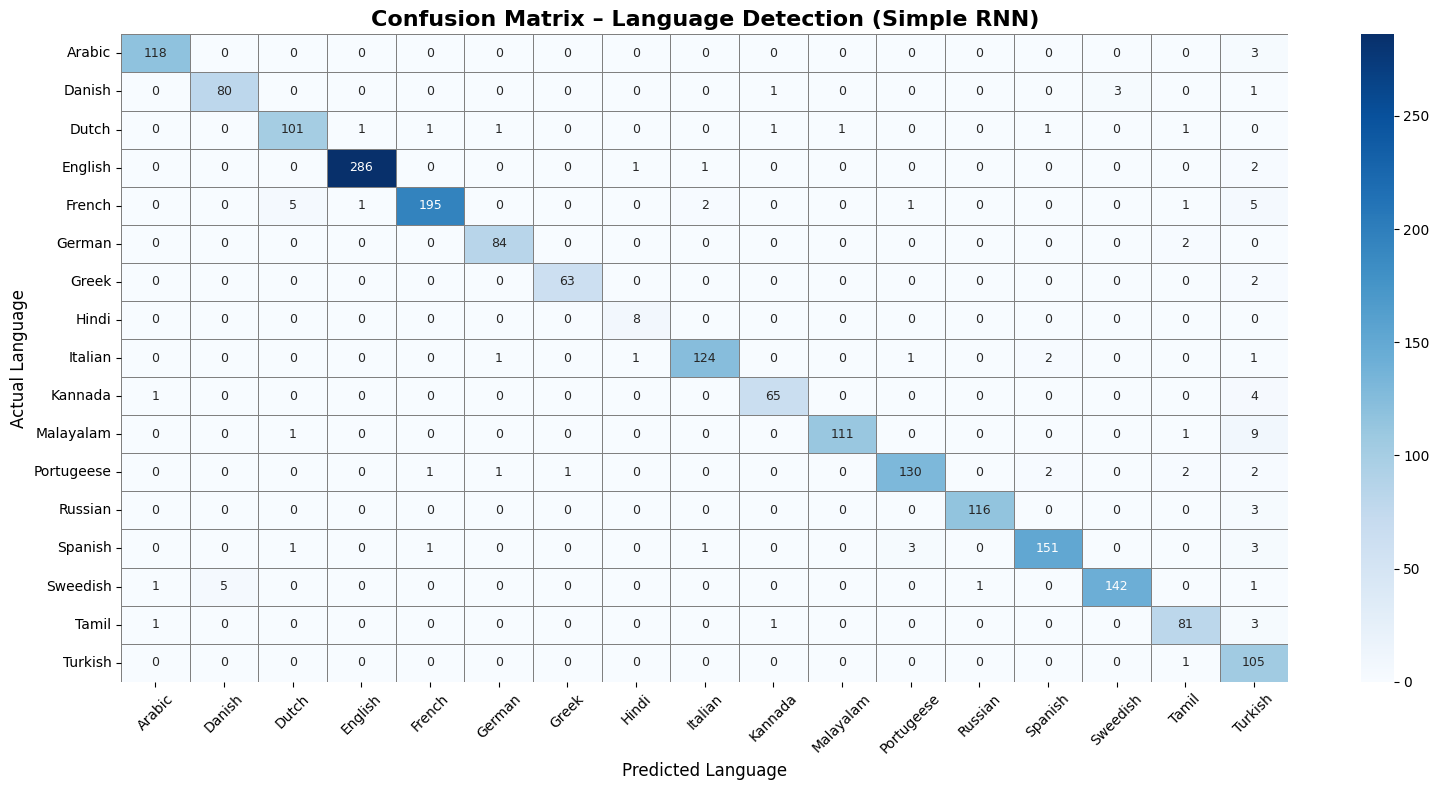

In [82]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="grey",
    xticklabels=classes_,
    yticklabels=classes_,
    annot_kws={"size": 9}
)

plt.title("Confusion Matrix – Language Detection (Simple RNN)", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Language", fontsize=12)
plt.ylabel("Actual Language", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()